## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [3]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [4]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.common)
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/home/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

In [5]:
date_str_from='2024-02-14'
date_str_to='2024-03-01'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [ ]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [ ]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

## calculate/cache feature

In [6]:
import algo.feature.jitter.calculate
importlib.reload(algo.feature.jitter.calculate)
import algo.feature.jitter.research
importlib.reload(algo.feature.jitter.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [7]:
feature_param = algo.feature.jitter.calculate.JitterFeatureParam(30)

In [8]:
algo.feature.jitter.research.get_feature_label_for_caching(feature_param)

'feature/(changes)_window(30)'

In [13]:
dfst_feature = algo.cache.read_df(
    label = algo.feature.jitter.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2024-03-01', 
    date_str_to='2024-03-03')

In [14]:
dfst_feature[['ch']]

,,ch
symbol,timestamp,
ALGO-USDT-SWAP,2024-03-01 00:00:00-05:00,0.000000
METIS-USDT-SWAP,2024-03-01 00:00:00-05:00,0.000000
DOGE-USDT-SWAP,2024-03-01 00:00:00-05:00,0.000000
AR-USDT-SWAP,2024-03-01 00:00:00-05:00,0.000000
OMG-USDT-SWAP,2024-03-01 00:00:00-05:00,0.000000
...,...,...
CEL-USDT-SWAP,2024-03-02 23:59:00-05:00,-0.003094
PYTH-USDT-SWAP,2024-03-02 23:59:00-05:00,0.006180
LINK-USDT-SWAP,2024-03-02 23:59:00-05:00,0.003761


In [38]:
dfst_feature['ch_rank'] = dfst_feature.groupby('timestamp')[['ch']].rank('average').rename(columns={'ch': 'ch_rank'})

In [39]:
dfst_feature['ch_rank_descending'] = dfst_feature.groupby('timestamp')[['ch']].rank('average', ascending=False).rename(columns={'ch': 'ch_rank_descending'})

In [19]:
dfst_feature.index.get_level_values(level='timestamp')

DatetimeIndex(['2024-03-01 00:00:00-05:00', '2024-03-01 00:00:00-05:00',
               '2024-03-01 00:00:00-05:00', '2024-03-01 00:00:00-05:00',
               '2024-03-01 00:00:00-05:00', '2024-03-01 00:00:00-05:00',
               '2024-03-01 00:00:00-05:00', '2024-03-01 00:00:00-05:00',
               '2024-03-01 00:00:00-05:00', '2024-03-01 00:00:00-05:00',
               ...
               '2024-03-02 23:59:00-05:00', '2024-03-02 23:59:00-05:00',
               '2024-03-02 23:59:00-05:00', '2024-03-02 23:59:00-05:00',
               '2024-03-02 23:59:00-05:00', '2024-03-02 23:59:00-05:00',
               '2024-03-02 23:59:00-05:00', '2024-03-02 23:59:00-05:00',
               '2024-03-02 23:59:00-05:00', '2024-03-02 23:59:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='timestamp', length=576724, freq=None)

In [29]:
dfst_feature[
  (dfst_feature.index.get_level_values(level='timestamp') == '2024-03-02 00:00:00-05:00')
][['ch', 'ch_rank']]

,,ch,ch_rank
symbol,timestamp,,
ADA-USDT-SWAP,2024-03-02 00:00:00-05:00,-0.008275,18.0
CRV-USDT-SWAP,2024-03-02 00:00:00-05:00,-0.006494,30.0
ETH-USDT-SWAP,2024-03-02 00:00:00-05:00,-0.001407,87.0
FLOKI-USDT-SWAP,2024-03-02 00:00:00-05:00,0.049743,173.0
ID-USDT-SWAP,2024-03-02 00:00:00-05:00,0.000487,111.0
...,...,...,...
SNX-USDT-SWAP,2024-03-02 00:00:00-05:00,-0.004852,44.0
BSV-USD-SWAP,2024-03-02 00:00:00-05:00,NaN,NaN
MANA-USD-SWAP,2024-03-02 00:00:00-05:00,NaN,NaN


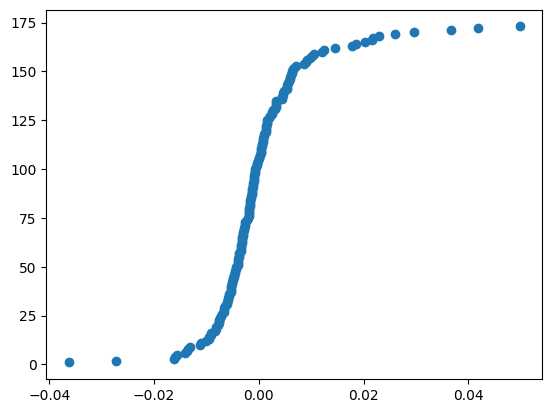

In [41]:
plt.scatter(
    dfst_feature[
  (dfst_feature.index.get_level_values(level='timestamp') == '2024-03-02 00:00:00-05:00')
][['ch']], 
    dfst_feature[(dfst_feature.index.get_level_values(level='timestamp') == '2024-03-02 00:00:00-05:00')
][['ch_rank']]
)

## multiple symbols

In [82]:
import algo.alpha.jitter_following.calculate
importlib.reload(algo.alpha.jitter_following.calculate)
import algo.alpha.jitter_following.research
importlib.reload(algo.alpha.jitter_following.research)

<module 'algo.alpha.jitter_following.research' from '/Users/junlim/projects/jitter_recovery/algo/alpha/jitter_following/research.py'>

In [83]:
trading_param = algo.alpha.jitter_following.calculate.JitterFollowingTradingParam(
    feature_param, 
    0.15, -0.02)

In [84]:
algo.alpha.jitter_following.research.get_trading_label_for_caching(trading_param)

'trading/(changes_following_trading)_feature_param(window(30))_jump_threshold(0.15)_exit_drop_threshold(-0.02)'

In [85]:
def plot_profit(date_str_from, date_str_to):
    dfst_trading = algo.cache.read_df(
        label = algo.jitter_following.research.get_trading_label_for_caching(trading_param),
        dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
        export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
        date_str_from=date_str_from, 
        date_str_to=date_str_to,
        columns=['profit', 'value', 'position_changed']
    )
    dfst_trading[['profit']].dropna().groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

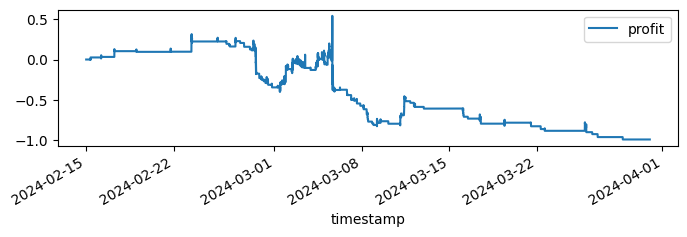

In [86]:
plot_profit('2024-02-15', '2024-03-31')

In [87]:
trading_param = algo.alpha.jitter_following.calculate.JitterFollowingTradingParam(
    feature_param, 
    0.15, -0.01)

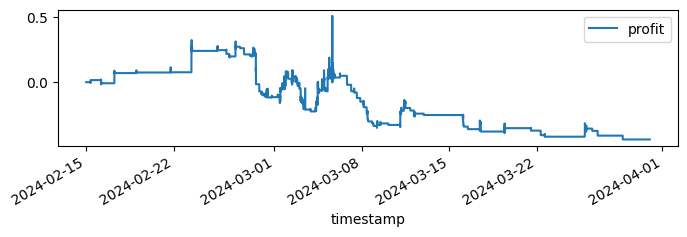

In [88]:
plot_profit('2024-02-15', '2024-03-31')

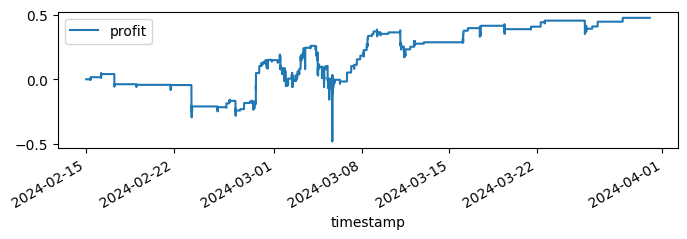

In [41]:
plot_profit('2024-02-15', '2024-03-31')

In [89]:
trading_param = algo.alpha.jitter_following.calculate.JitterFollowingTradingParam(
    feature_param, 
    0.20, -0.02)

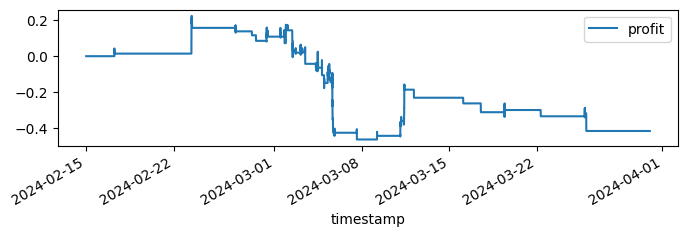

In [90]:
plot_profit('2024-02-15', '2024-03-31')

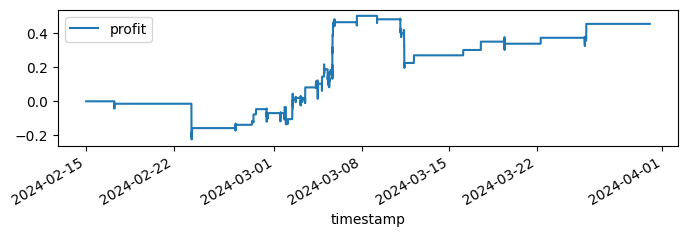

In [44]:
plot_profit('2024-02-15', '2024-03-31')

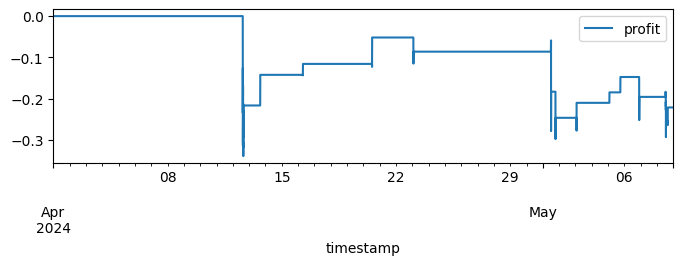

In [45]:
plot_profit('2024-04-01', '2024-05-09')

In [91]:
trading_param = algo.alpha.jitter_following.calculate.JitterFollowingTradingParam(
    feature_param, 
    0.20, -0.01)

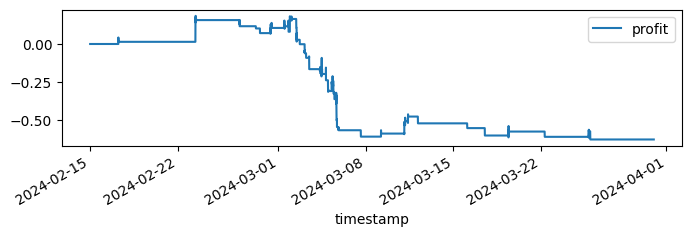

In [92]:
plot_profit('2024-02-15', '2024-03-31')

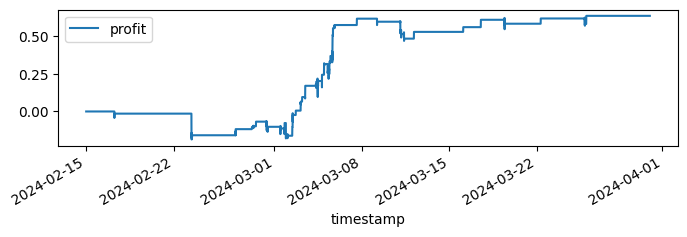

In [48]:
plot_profit('2024-02-15', '2024-03-31')

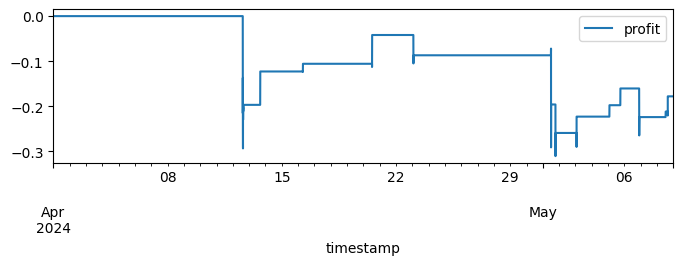

In [49]:
plot_profit('2024-04-01', '2024-05-09')

In [51]:
dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
FITFI-USDT-SWAP,-0.167572
LOOKS-USDT-SWAP,-0.149975
CEL-USDT-SWAP,-0.097686
ZERO-USDT-SWAP,-0.063596
CORE-USDT-SWAP,-0.044736
JUP-USDT-SWAP,0.001465
ARB-USDT-SWAP,0.005995
MEW-USDT-SWAP,0.017096
ZETA-USDT-SWAP,0.018758


In [50]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-12 14:36:00-04:00, LOOKS-USDT-SWAP, 0.1081, position_changed: 1.0
2024-04-12 14:36:00-04:00, FITFI-USDT-SWAP, 0.006373, position_changed: 1.0
2024-04-12 14:37:00-04:00, YFI-USDT-SWAP, 7395.0, position_changed: 1.0
2024-04-12 14:37:00-04:00, BIGTIME-USDT-SWAP, 0.2027, position_changed: 1.0
2024-04-12 14:38:00-04:00, YFI-USDT-SWAP, 6863.0, position_changed: -1.0
2024-04-12 14:38:00-04:00, CORE-USDT-SWAP, 1.3771, position_changed: 1.0
2024-04-12 14:38:00-04:00, BIGTIME-USDT-SWAP, 0.1961, position_changed: -1.0
2024-04-12 14:41:00-04:00, ARB-USDT-SWAP, 1.0916, position_changed: 1.0
2024-04-12 14:41:00-04:00, JUP-USDT-SWAP, 0.9768, position_changed: 1.0
2024-04-12 14:41:00-04:00, LOOKS-USDT-SWAP, 0.12138, position_changed: -1.0
2024-04-12 14:41:00-04:00, PEPE-USDT-SWAP, 5.411e-06, position_changed: 1.0
2024-04-12 14:42:00-04:00, PEPE-USDT-SWAP, 5.312e-06, position_changed: -1.0
2024-04-12 14:43:00-04:00, LOOKS-USDT-SWAP, 0.12533, position_changed: 1.0
2024-04-12 14:44:00-04:00, BIGT

## single symbol

In [67]:
import algo.jitter_following.calculate
importlib.reload(algo.jitter_following.calculate)
import algo.jitter_following.research
importlib.reload(algo.jitter_following.research)
import algo.jitter_common.research
importlib.reload(algo.jitter_common.research)

<module 'algo.jitter_common.research' from '/Users/junlim/projects/jitter_recovery/algo/jitter_common/research.py'>

In [60]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    aggregation_mode = market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-04-01', date_str_to='2024-05-09').reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [61]:
symbol_investigate = 'FITFI-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [62]:
dfs

,index,open,high,low,close,volume
timestamp,,,,,,
2024-04-01 00:00:00-04:00,4362298,0.012673,0.012683,0.012646,0.012683,344180.0
2024-04-01 00:01:00-04:00,4362299,0.012681,0.012681,0.012656,0.012662,273920.0
2024-04-01 00:02:00-04:00,4362300,0.012656,0.012677,0.012656,0.012677,86390.0
2024-04-01 00:03:00-04:00,4362301,0.012669,0.012669,0.012653,0.012653,151860.0
2024-04-01 00:04:00-04:00,4362302,0.012657,0.012657,0.012646,0.012646,124210.0
...,...,...,...,...,...,...
2024-05-08 23:55:00-04:00,4417013,0.006881,0.006886,0.006881,0.006882,42540.0
2024-05-08 23:56:00-04:00,4417014,0.006880,0.006884,0.006880,0.006884,196290.0
2024-05-08 23:57:00-04:00,4417015,0.006882,0.006888,0.006882,0.006888,31830.0


In [51]:
trading_param = algo.jitter_following.calculate.JitterFollowingTradingParam(
    feature_param, 
    0.20, -0.01)

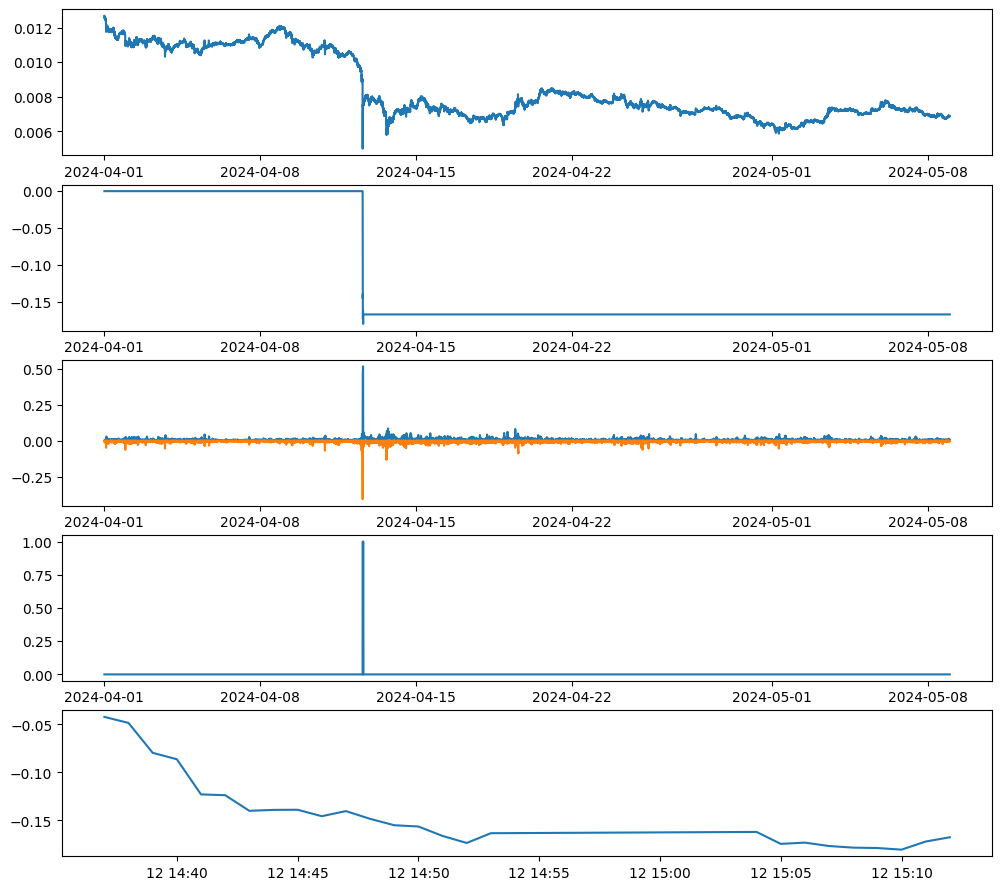

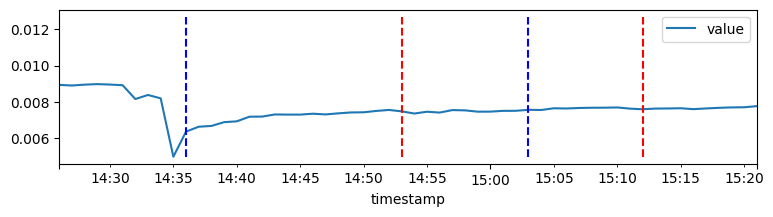

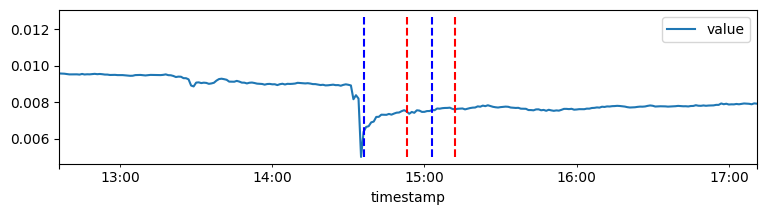

In [68]:
df_feature, df_trading = algo.jitter_common.research.investigate_symbol(df, symbol_investigate, algo.jitter_following.research.add_trading_columns, trading_param, figsize=(12, 11))

In [69]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-04-12 14:36:00-04:00,0.006373,1,1.0,-0.000000,-0.000000
2024-04-12 14:53:00-04:00,0.007486,0,-1.0,0.000077,0.010181
2024-04-12 15:03:00-04:00,0.007570,1,1.0,-0.000000,-0.000000
2024-04-12 15:12:00-04:00,0.007601,0,-1.0,0.000034,0.004453


In [70]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-04-12 14:36:00-04:00, FITFI-USDT-SWAP, 0.006373, position_changed: 1.0
2024-04-12 14:53:00-04:00, FITFI-USDT-SWAP, 0.007486, position_changed: -1.0
2024-04-12 15:03:00-04:00, FITFI-USDT-SWAP, 0.00757, position_changed: 1.0
2024-04-12 15:12:00-04:00, FITFI-USDT-SWAP, 0.007601, position_changed: -1.0
